In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  # Import ajouté qui manquait
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import gymnasium as gym
from gymnasium import spaces
import random
from collections import deque
import re
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle

Exercice 1: Préparation des données

In [6]:
# Chargement des données (utilisez votre propre chemin de fichier)
df = pd.read_csv('Data/fake_job_postings.csv')
print(f"Forme du dataset: {df.shape}")
print(f"Distribution des classes: \n{df['fraudulent'].value_counts()}")


Forme du dataset: (17880, 18)
Distribution des classes: 
fraudulent
0    17014
1      866
Name: count, dtype: int64


In [7]:
# Préparation du texte
df['title'] = df['title'].fillna('')
df['description'] = df['description'].fillna('')
df['text'] = df['title'] + ' ' + df['description']

In [8]:
# Nettoyage du texte
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower().strip()

df['text'] = df['text'].apply(clean_text)


In [9]:
# Vectorisation du texte
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text']).toarray()
y = df['fraudulent'].values


In [10]:
# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Dimensions X_train: {X_train.shape}")
print(f"Dimensions X_test: {X_test.shape}")


Dimensions X_train: (14304, 5000)
Dimensions X_test: (3576, 5000)


### Exercice 2: Modélisation en Environnement RL

In [11]:
class JobClassificationEnv(gym.Env):
    def __init__(self, features, labels):
        super(JobClassificationEnv, self).__init__()
        self.features = features
        self.labels = labels
        self.current_index = 0
        self.current_state = None
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(features.shape[1],), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        
    def reset(self, seed=None, options=None):
        # Correction selon l'API Gymnasium actuelle
        if seed is not None:
            super().reset(seed=seed)
        else:
            super().reset()
            
        if options is None:
            options = {}
        self.current_index = random.randint(0, len(self.features) - 1)
        self.current_state = self.features[self.current_index].astype(np.float32)
        return self.current_state, {}
    
    def step(self, action):
        reward = 1.0 if action == self.labels[self.current_index] else -1.0
        done = True
        truncated = False
        info = {}
        return self.current_state, reward, done, truncated, info


In [12]:
# Création des environnements
train_env = JobClassificationEnv(X_train, y_train)
test_env = JobClassificationEnv(X_test, y_test)


### Exercice 3: Création du modèle DQN et entraînement

In [13]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            act_values = self.model(state_tensor)
            return torch.argmax(act_values[0]).item()
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            target = reward
            if not done:
                with torch.no_grad():
                    target = reward + self.gamma * torch.max(self.model(next_state_tensor)[0]).item()
            current_q = self.model(state_tensor)[0]
            target_f = current_q.clone()
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = self.criterion(current_q, target_f)
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def load(self, name):
        self.model.load_state_dict(torch.load(name))
    
    def save(self, name):
        torch.save(self.model.state_dict(), name)

In [16]:
# Initialisation et entraînement
state_size = X_train.shape[1]
action_size = 2
agent = DQNAgent(state_size, action_size)
batch_size = 32
EPISODES = 1000

In [17]:
losses = []  # Pour suivre les pertes
epsilons = []  # Pour suivre l'epsilon

In [18]:
for e in range(EPISODES):
    state, _ = train_env.reset()
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = train_env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
    agent.replay(batch_size)
    epsilons.append(agent.epsilon)
    if (e + 1) % 100 == 0:
        print(f"Episode: {e+1}/{EPISODES}, Epsilon: {agent.epsilon:.2f}")


Episode: 100/1000, Epsilon: 0.71
Episode: 200/1000, Epsilon: 0.43
Episode: 300/1000, Epsilon: 0.26
Episode: 400/1000, Epsilon: 0.16
Episode: 500/1000, Epsilon: 0.10
Episode: 600/1000, Epsilon: 0.06
Episode: 700/1000, Epsilon: 0.03
Episode: 800/1000, Epsilon: 0.02
Episode: 900/1000, Epsilon: 0.01
Episode: 1000/1000, Epsilon: 0.01


In [19]:
# Sauvegarde du modèle
agent.save('fake_job_dqn_model.pth')
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [20]:
# Évaluation du modèle
y_pred = []
q_values_list = []
with torch.no_grad():
    for i in range(len(X_test)):
        state = X_test[i].astype(np.float32)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = agent.model(state_tensor)
        action = torch.argmax(q_values[0]).item()
        y_pred.append(action)
        q_values_list.append(q_values[0].numpy())


In [21]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Précision: 0.9575
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3403
           1       0.61      0.34      0.43       173

    accuracy                           0.96      3576
   macro avg       0.79      0.66      0.71      3576
weighted avg       0.95      0.96      0.95      3576



In [22]:
# 3D Plot of Q-values - visualisation interactive avec plt.ion()
plt.ion()  # Active le mode interactif
sample_size = min(100, len(X_test))  # Limite à 100 exemples pour la visualisation
q_values_sample = np.array(q_values_list[:sample_size])
indices = np.arange(sample_size)
q_real = q_values_sample[:, 0]
q_fake = q_values_sample[:, 1]


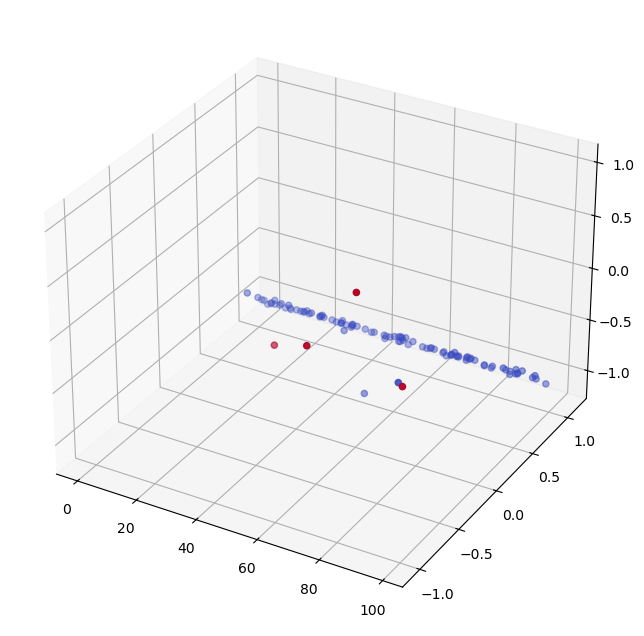

In [23]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(indices, q_real, q_fake, c=y_test[:sample_size], cmap='coolwarm', marker='o')


In [24]:
ax.set_xlabel('Sample Index')
ax.set_ylabel('Q-value (Real)')
ax.set_zlabel('Q-value (Fake)')
ax.set_title('3D Plot of Q-values for Test Samples')

Text(0.5, 0.92, '3D Plot of Q-values for Test Samples')

In [32]:
# Ajout d'une barre de couleur
cbar = plt.colorbar(scatter)
cbar.set_label('Class (0=Real, 1=Fraudulent)')
plt.show()

C:\Windows\Temp\ipykernel_6336\4290950893.py:2: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 3 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(scatter)


<Figure size 640x480 with 0 Axes>

### Exercice 4: Test en situation réelle

In [27]:
new_job = {
    'title': 'Data Scientist - Remote Work',
    'description': 'Exciting opportunity for a Data Scientist to join our team! Must have 3+ years of experience in machine learning and Python. Work from home with competitive salary. Send your CV and bank details for direct payment processing.'
}

In [28]:
new_text = clean_text(new_job['title'] + ' ' + new_job['description'])
new_features = vectorizer.transform([new_text]).toarray().astype(np.float32)


In [29]:
with torch.no_grad():
    state_tensor = torch.FloatTensor(new_features[0]).unsqueeze(0)
    q_values = agent.model(state_tensor)
    prediction = torch.argmax(q_values[0]).item()


In [30]:
print(f"Nouvelle offre: {new_job['title']}")
print(f"Prédiction: {'FAUSSE' if prediction == 1 else 'RÉELLE'}")
print(f"Q-values: {q_values[0].numpy()}")


Nouvelle offre: Data Scientist - Remote Work
Prédiction: RÉELLE
Q-values: [ 0.7639858 -0.8557677]


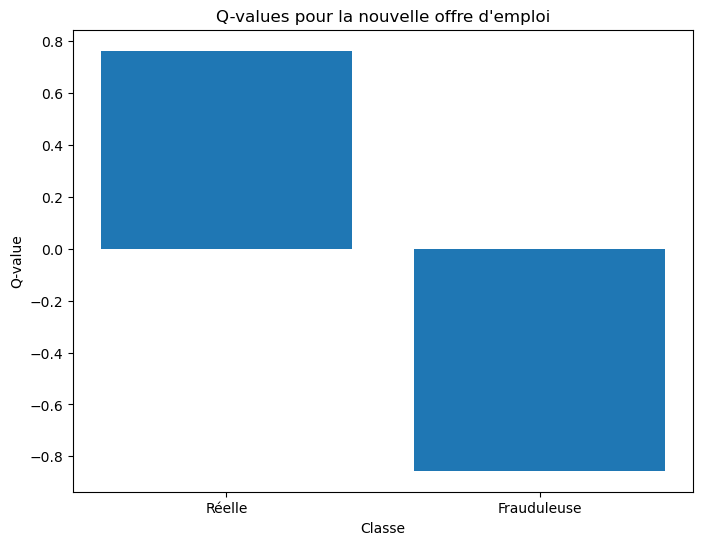

In [31]:
# Visualisation des Q-values pour la nouvelle offre
plt.figure(figsize=(8, 6))
classes = ['Réelle', 'Frauduleuse']
plt.bar(classes, q_values[0].numpy())
plt.title('Q-values pour la nouvelle offre d\'emploi')
plt.xlabel('Classe')
plt.ylabel('Q-value')
plt.show()
